## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
torch.__version__

'2.3.0+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [3]:
from torchvision.datasets import Food101
from torch.utils.data import DataLoader

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a datafolder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it ...
if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download")
else:
    print(f"{image_path} doen't exist, downloading...")
    image_path.mkdir(parents=True, exist_ok=True)
# Download pizza/steak/sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza/steak/sushi data...")
    f.write(request.content)
# Unzip pizza/steak/sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", 'r') as zip_ref:
    print("Unzipping pizza/steak/sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, skipping download
Unzipping pizza/steak/sushi data...


## 2. Becoming one with the data (data prepperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in `data/pizza_steak_sushi`
There are 3 directories and 0 images in `data/pizza_steak_sushi/train`
There are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`
There are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`
There are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`
There are 3 directories and 0 images in `data/pizza_steak_sushi/test`
There are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`
There are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`
There are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image
Let's write some code to:
1. get all the image paths
2. pick a random image path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. since we're working with images, let's open the image with python's PIL
5. we'll then show the image and print metadata

steak
Image path : data/pizza_steak_sushi/train/steak/560503.jpg
Image class : steak
Image size : (512, 512)
Image height : 512
Image width : 512


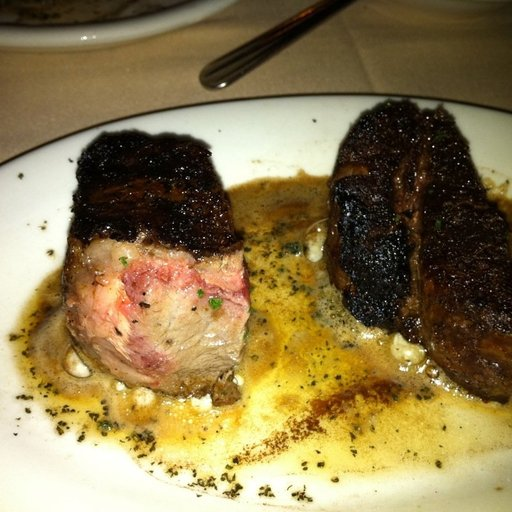

In [8]:
import matplotlib.pyplot as plt
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name (the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print Metadata
print(f"Image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image size : {img.size}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

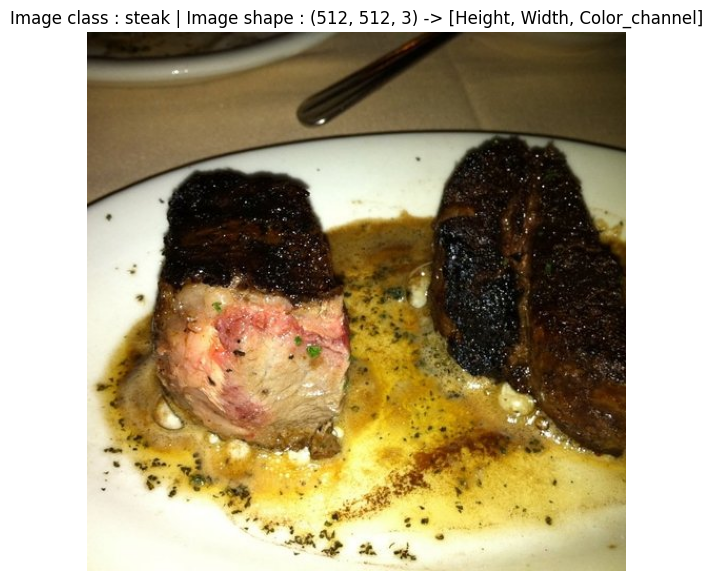

In [9]:
# plt.imshow(img)
# plt.title(image_class)
# plt.axis("off")
# plt.xlabel(img.height)
# plt.ylabel(img.width)
# plt.show();
# This code is what i wrote

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [Height, Width, Color_channel]")
plt.axis(False)
plt.show();

## 3. Transforming data

1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, We'll call these Datasets and DataLoader for short.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64*64
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

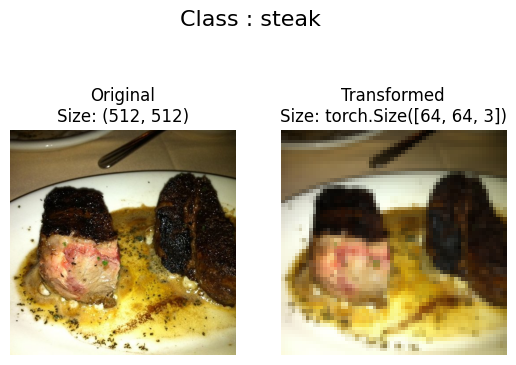

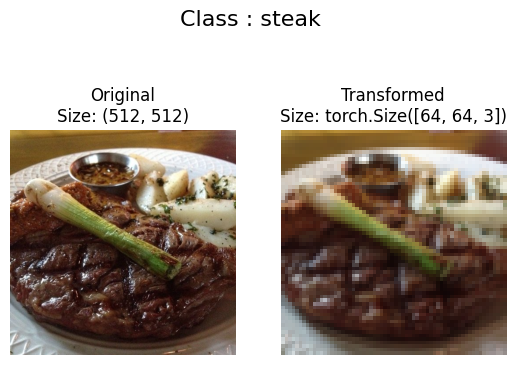

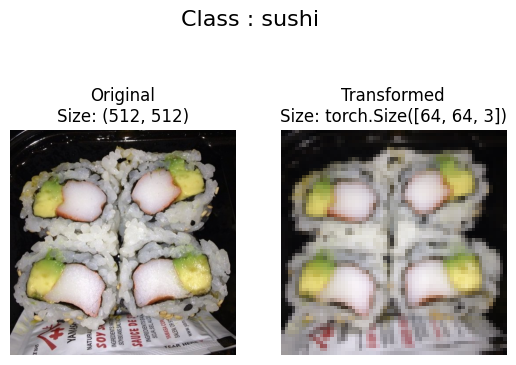

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and plots them with their transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig , ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target images
            transformed_image = transform(f).permute(1, 2, 0) # Without .permute() this code will return an error (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


## 4. Option 1 : Loading image data using `ImageFolder`

In [14]:
# USe imagefolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)
train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train_data dataset to get a single image and a label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image Dtype : {img.dtype}")
print(f"Image label: {label}")
print(f"Image label name : {class_names[label]}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
New shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


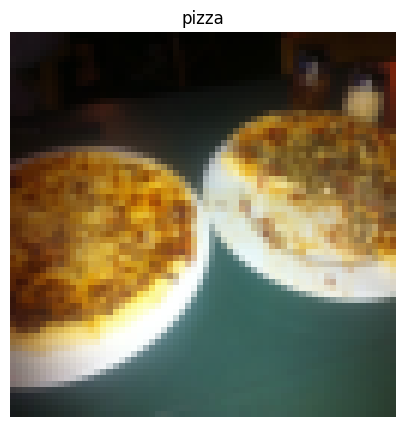

In [19]:
# REarrange the order of dimensions
img_permute = img.permute(1, 2, 0)
# Print out shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"New shape: {img_permute.shape} -> [height, width, color_channels]")
plt.figure(figsize=(7, 5))
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis("off")
plt.show();

## 4.1 Turn loaded images into DataLoaders

In [20]:
import os
os.cpu_count()

2

In [21]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers=1,  shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers=1, shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e89c3ddff40>,
 <torch.utils.data.dataloader.DataLoader at 0x7e89c3ddec80>)

In [22]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1
print(f"Image batch shape: {img.shape} -> [batch_size , color_channels, height, width]")
print(f"Label batch shape: {label.shape}")

Image batch shape: torch.Size([1, 3, 64, 64]) -> [batch_size , color_channels, height, width]
Label batch shape: torch.Size([1])


## 5. Option 2 : Loading image data with a custom `Dataset`

1. Wamt to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionaries from the Dataset

Pros
* Create a `Dataset` out of almost anything
* You're not limited to pytorch pre-built functions

Cons:
* Even though you could create `Dataset` out of almost anything , it doesnt mean that it will work...
* Using a custom `Dataset` often results in us writing more code which could be prone to errors or performance issues

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

we want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structures).
3. Turn the class names into a dict and a list and return them.

In [24]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in os.scandir(target_directory)])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [25]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")
    # 3. Create a dictionary of index labels
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    # 3. Turn the class names into a dictionary
    return classes, class_to_idx

In [26]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

To create our own custom dataset we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we want to get data from) as well as a transform.
3. Create several attributes:
 * paths - paths of our images
 * transform - the transform we want to use
 * classes - a list of target classes
 * class_to_idx - a dict of target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method, to return the length og our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [27]:
# Write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass.torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initilize our custom dataset
    def __init__(self, targ_dir:str, transform = None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup trasform
        self.transform = transform
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)
    # 4. Create a function to load images
    def load_image(self, index:int) -> Image.Image:
        """Opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    # 5. Overwrite __len__()
    def __len__(self) -> int:
      "Returns total number of samples"
      return len(self.paths)
    # 6. Overwrite __getitem()__ method to return our wanted sample
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        # Transform if necessary
        if self.transform is not None:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [28]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [29]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check for equality betweem  original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(train_data_custom.class_to_idx==train_data.class_to_idx)
print(test_data_custom.classes==test_data.classes)
print(test_data_custom.class_to_idx==test_data.class_to_idx)

True
True
True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters
2. To prevent the display getting out of hand , see 10 images.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [32]:
# 1. Create a function
def display_random_images(dataset:torch.utils.data.Dataset,
                           classes:List[str]=None,
                           n:int=10,
                           display_shape:bool=True,
                           seed:int=None):
    # 2. Adjust display if n is too high
    if n>10:
        n=10
        display_shape=False
    # 3. Set the seed
    if seed:
        random.seed(seed)
    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # Setup plot
    plt.figure(figsize=(16, 8))


    # 6. Loop through random indexes and plot them
    for i , targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\n Shape: {targ_image.shape}"
        plt.title(title)

        plt.axis(False)


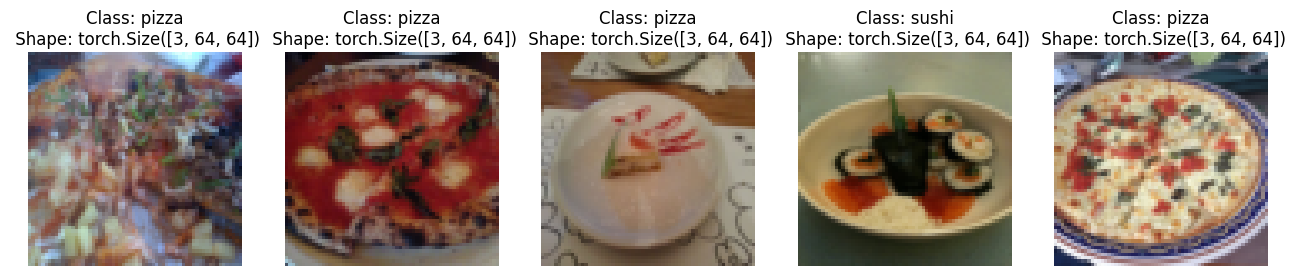

In [33]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

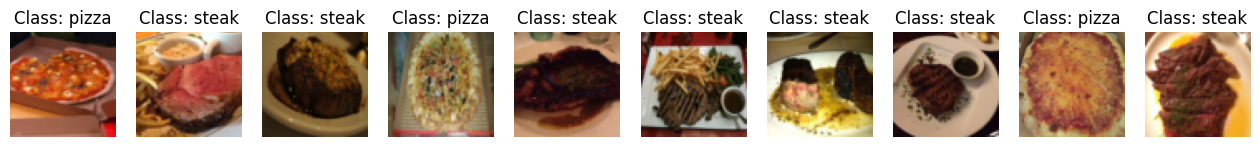

In [34]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Return custom loaded images into DataLoader's

In [35]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, shuffle=False)
len(train_dataloader_custom), len(test_dataloader_custom)

(225, 75)

In [36]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)
### Data augmentation is the process of artificially adding diversity to your training data.


In [37]:
# Let's look at TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [38]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[0:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/234626.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/914570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1225762.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/830007.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/421476.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2825100.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg')]

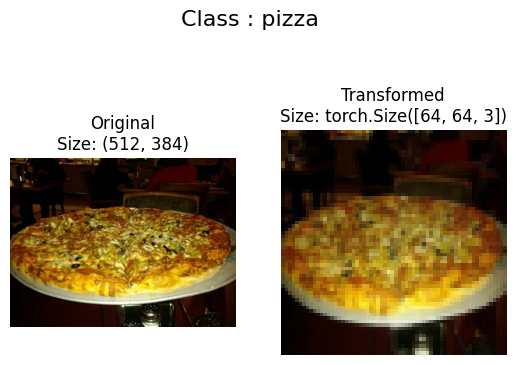

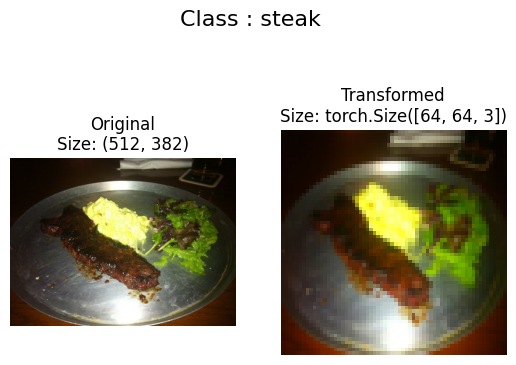

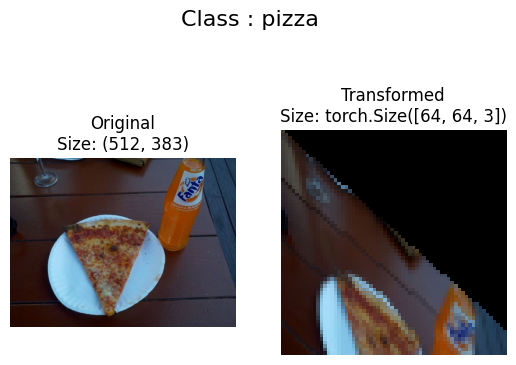

In [39]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0 : TinyVGG Without data augmentation
Let's replicate the tinyvgg architecture.

### 7.1 Creating transforms and loading data for model 0

In [40]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [41]:
# 1. Load and transform data
from torchvision import datasets
train_dir = image_path / "train"
test_dir = image_path / "test"
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform,target_transform=None )
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)

In [42]:
# 2. Turn datasets into dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

### 7.2 Create TinyVGG model class

In [43]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*196, out_features=output_shape)
        )
    def forward(self, x:torch.tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x

In [44]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # Number of color channels
                  hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=3, bias=True)
  )
)

# 7.3 Try a forward pass on a single image

In [45]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [46]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0407,  0.0301, -0.0181],
        [-0.0353,  0.0179, -0.0042],
        [-0.0296,  0.0316, -0.0189],
        [-0.0381,  0.0284, -0.0189],
        [-0.0329,  0.0270, -0.0056],
        [-0.0285,  0.0279, -0.0083],
        [-0.0346,  0.0237, -0.0149],
        [-0.0169,  0.0301, -0.0022],
        [-0.0444,  0.0215, -0.0203],
        [-0.0293,  0.0319, -0.0095],
        [-0.0402,  0.0308, -0.0203],
        [-0.0420,  0.0214, -0.0176],
        [-0.0413,  0.0295, -0.0185],
        [-0.0271,  0.0287, -0.0086],
        [-0.0335,  0.0291, -0.0160],
        [-0.0404,  0.0212, -0.0190],
        [-0.0358,  0.0366, -0.0106],
        [-0.0379,  0.0319, -0.0158],
        [-0.0289,  0.0290, -0.0211],
        [-0.0368,  0.0258, -0.0165],
        [-0.0430,  0.0259, -0.0209],
        [-0.0319,  0.0280, -0.0107],
        [-0.0393,  0.0258, -0.0172],
        [-0.0333,  0.0356, -0.0227],
        [-0.0397,  0.0333, -0.0110],
        [-0.0418,  0.0255, -0.0137],
        [-0.0366,  0.0255, -0.0182],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [47]:
pip install torchinfo

In [48]:
from torchinfo import summary
summary(model_0, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 31, 31]          --
│    └─Conv2d: 2-1                       [32, 10, 63, 63]          130
│    └─ReLU: 2-2                         [32, 10, 63, 63]          --
│    └─Conv2d: 2-3                       [32, 10, 62, 62]          410
│    └─ReLU: 2-4                         [32, 10, 62, 62]          --
│    └─MaxPool2d: 2-5                    [32, 10, 31, 31]          --
├─Sequential: 1-2                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-6                       [32, 10, 30, 30]          410
│    └─ReLU: 2-7                         [32, 10, 30, 30]          --
│    └─Conv2d: 2-8                       [32, 10, 29, 29]          410
│    └─ReLU: 2-9                         [32, 10, 29, 29]          --
│    └─MaxPool2d: 2-10                   [32, 10, 14, 14]          --
├─Sequentia

### 7.5 Create train and test loops functions

In [49]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [50]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_pred_class = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_class == y).sum().item()/len(test_pred)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Create a `train()` function (combine `train_step()` and `test_step()`)

In [51]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int = 10,
          device=device):
    # 1. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                         dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)
        # Print out whats happening

        print(f"Epoch: {epoch} | Train loss : {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        # Update our results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # Return the filled results at then of the epoch
    return results

### 7.7 Train and evaluate model_0

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(end_time - start_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.1041 | Train acc: 0.2500 | Test loss: 1.0926 | Test acc: 0.2812
Epoch: 1 | Train loss : 1.0706 | Train acc: 0.4297 | Test loss: 1.1122 | Test acc: 0.2604
Epoch: 2 | Train loss : 1.0594 | Train acc: 0.4258 | Test loss: 1.1433 | Test acc: 0.2604
Epoch: 3 | Train loss : 1.0854 | Train acc: 0.3086 | Test loss: 1.1236 | Test acc: 0.2917
Epoch: 4 | Train loss : 1.0325 | Train acc: 0.5508 | Test loss: 1.0949 | Test acc: 0.3542
15.64483995799992


 ## 7.8 Plot the lost curves of model 0


In [53]:
# Get the model_0_results
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [54]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss,  label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

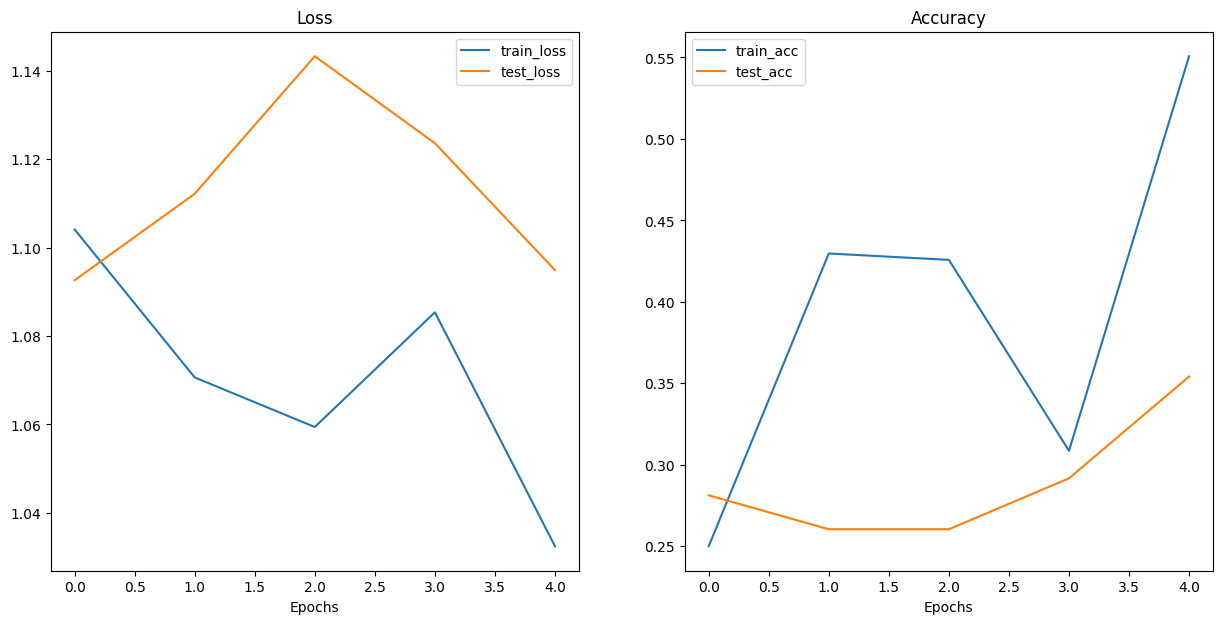

In [55]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like ?
You should pervent underfitting and overfitting

## 9. Model 1 : TinyVGG With Data Augmentation


### 9.1 Create a transform with data Augmentation


In [56]:
# Create transform with data augmentation
from torchvision import transforms
train_transform_trivial = transforms.Compose(
    [transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()]
)
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Datasets` and `DataLoaders` with data augmentation

In [57]:
train_data_augmented = datasets.ImageFolder(root=train_dir, transform = train_transform_trivial, target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir, transform = test_transform_simple)

In [58]:
# Turn our datasets into dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size= BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1
Same model but different data (augmented)

In [59]:
# Create model 1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=3, bias=True)
  )
)

Let's create a loss_fn and an optimizer

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple,optimizer=optimizer, loss_fn = loss_fn, epochs=NUM_EPOCHS, device=device)
end_time = timer()
print(end_time - start_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.1060 | Train acc: 0.2500 | Test loss: 1.0947 | Test acc: 0.2604
Epoch: 1 | Train loss : 1.0794 | Train acc: 0.4258 | Test loss: 1.1141 | Test acc: 0.2604
Epoch: 2 | Train loss : 1.0651 | Train acc: 0.4258 | Test loss: 1.1378 | Test acc: 0.2604
Epoch: 3 | Train loss : 1.1101 | Train acc: 0.3047 | Test loss: 1.1365 | Test acc: 0.2604
Epoch: 4 | Train loss : 1.0539 | Train acc: 0.4492 | Test loss: 1.1154 | Test acc: 0.2917
18.955572077999932


### 9.4 Plot the loss curves

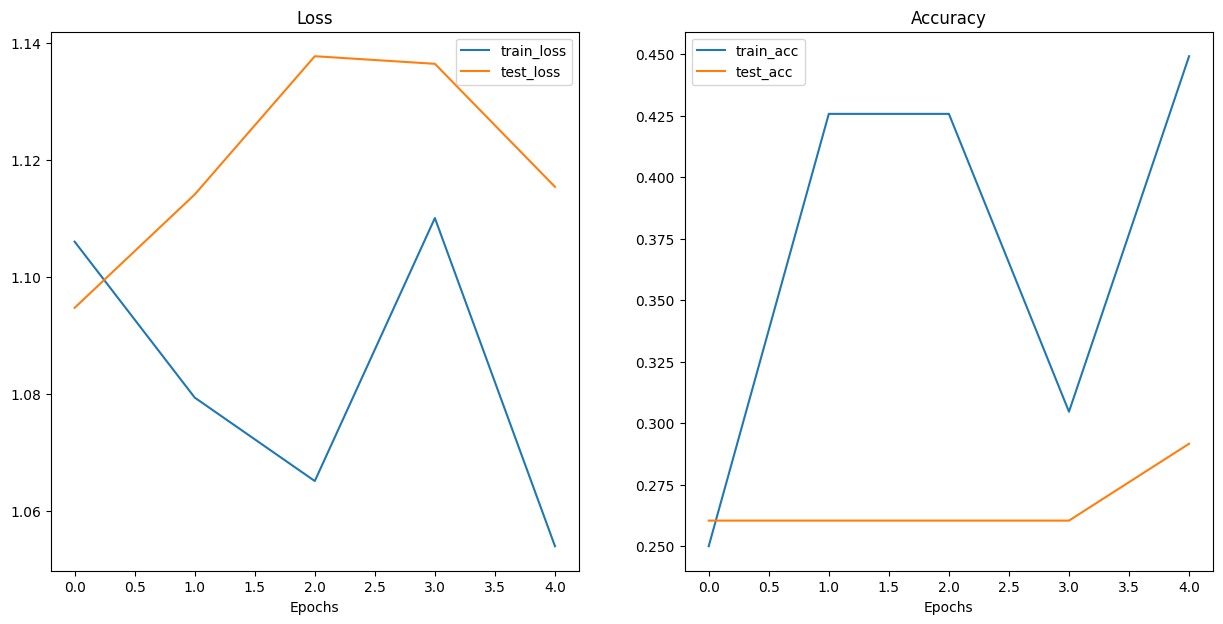

In [61]:
plot_loss_curves(model_1_results)

## 10. Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [62]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.104096,0.250000,1.092600,0.281250
1,1.070629,0.429688,1.112169,0.260417
2,1.059412,0.425781,1.143279,0.260417
3,1.085358,0.308594,1.123612,0.291667
4,1.032452,0.550781,1.094910,0.354167


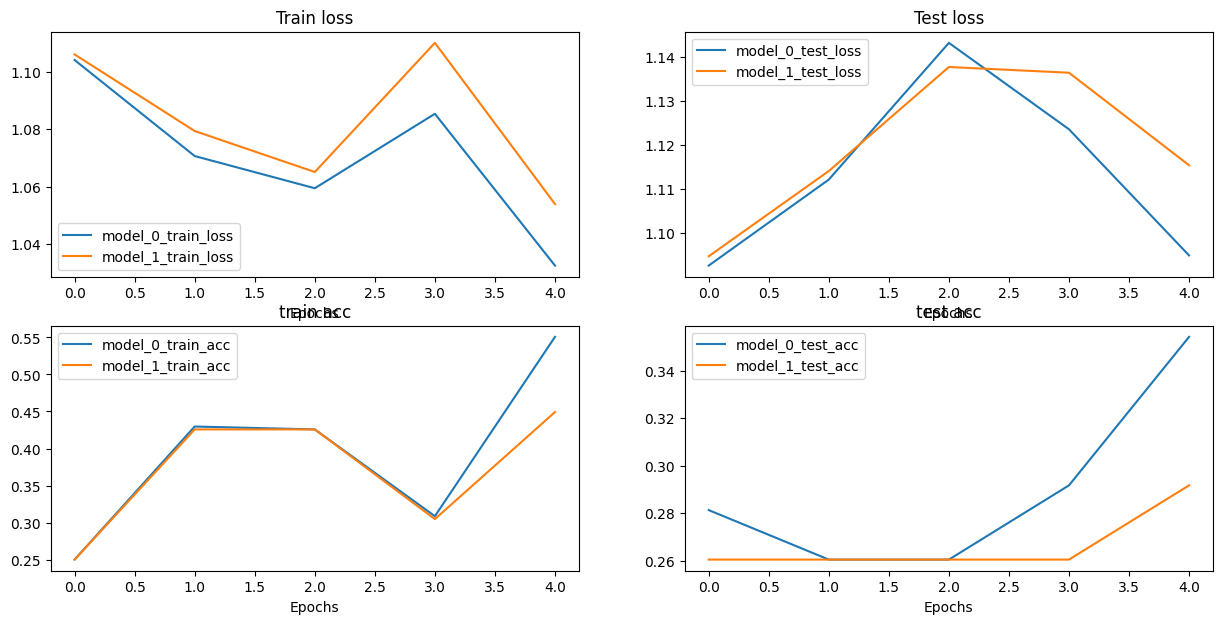

In [70]:
# Setup a plot to compare
plt.figure(figsize=(15, 7))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0_train_loss")
plt.plot(epochs, model_1_df["train_loss"], label="model_1_train_loss")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0_test_loss")
plt.plot(epochs, model_1_df["test_loss"], label="model_1_test_loss")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0_train_acc")
plt.plot(epochs, model_1_df["train_acc"], label="model_1_train_acc")
plt.title("train acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0_test_acc")
plt.plot(epochs, model_1_df["test_acc"], label="model_1_test_acc")
plt.title("test acc")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

In [77]:
# # Download a custom image
# import requests
# # Setup custom image path
# custom_image_path = data_path / "04-pizza-dad.jpg"
# # Download the image if it doesnt exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/0fa794be523a10b409a2061e43ae03c419d5ace7/images/04-pizza-dad.jpeg")
#         print("Downloaded custom image...")
#         f.write(request.content)
# else:
#     print("Custom image already exists...")

Downloaded custom image...


### 11.1 Loading in a custom image with pytorch
We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [162]:
import torchvision
custom_image_path = data_path / "04-pizza-dad.jpeg"
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

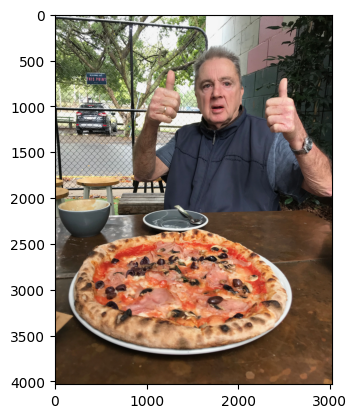

In [163]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [164]:
custom_image_float32 = custom_image_uint8.type(torch.float32)
custom_image_float32.shape

torch.Size([3, 4032, 3024])

In [165]:
from torchvision import transforms
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image.shape

torch.Size([3, 4032, 3024])

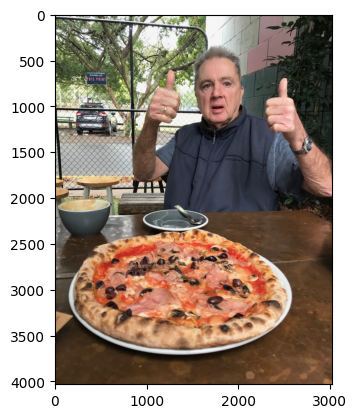

In [166]:
plt.imshow(custom_image.permute(1, 2, 0))

In [167]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])
custom_image_transform_1 = custom_image_transform(custom_image)
custom_image_transform_1.shape

torch.Size([3, 64, 64])

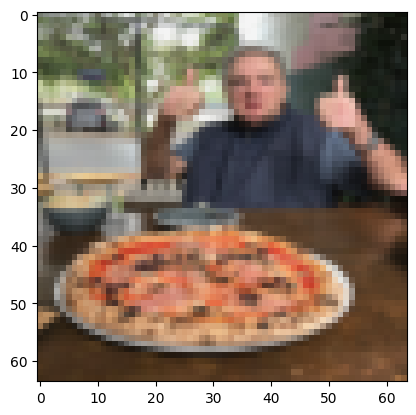

In [168]:
plt.imshow(custom_image_transform_1.permute(1, 2, 0))
plt.imshow(custom_image_transform_2.permute(1, 2, 0))

In [171]:
 # Try to predict on format float32
 # This will error : No Batchsize
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transform_1.unsqueeze(0))

In [172]:
custom_image_transform_1.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [173]:
 # Try to predict on format float32
 # This will error : No Batchsize
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transform_1.unsqueeze(0))
custom_image_pred

tensor([[ 0.0578, -0.0528, -0.2428]])

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [174]:
class_names[custom_image_pred.argmax()]

'pizza'

In [175]:
# Convert logits to prediction labels
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3794, 0.3397, 0.2809]])

In [176]:
# Convert prediciton probs to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0])

In [177]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediciton together : Building a function
The ideal outcome is a function where we pass an image path to our model to predict on it , and it returns the prediction label and prediction

In [178]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    # Divide the image pixel values by 255
    target_image = target_image/255.
    # Transform if necesery
    if transform:
        target_image = transform(target_image)
    # Make sure the model is one target device
    model.to(device)
    # Turn on eval
    model.eval()
    with torch.inference_mode():
        # Add a batch dimension
        target_image = target_image.unsqueeze(0)
        # Make a prediciton
        target_image_pred = model(target_image.to(device))
    # Convert the logits
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # Convert pred probs --> pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # Plot the image with prediciton label
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        plt.title(f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}")
    else:
        plt.title(f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}")
    plt.axis(False);

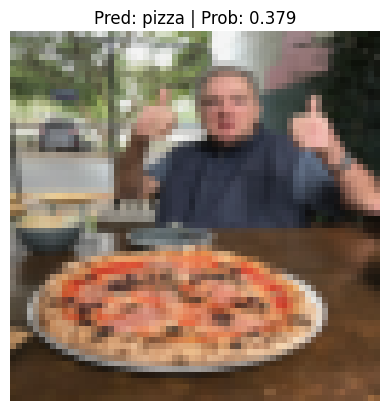

In [179]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)